### Noise calculations for paper revisions


This notebook explores the model training noise as requested during the first round of paper review.

We use the conda environment `analysis`


#### Define some useful functions

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None #Ignore SettingWithCopyWarning - we are safe here

def load_predictions(path):

    df = pd.read_parquet(path+'predictions.parquet')
    
    
    #Calculate some extra columns
    df['model_predicion_bias'] = df.MODIS_LST - df.predictions
    df['model_predicion_error'] = abs(df.MODIS_LST - df.predictions)
        
    df['ERA_predicion_bias'] = df.MODIS_LST - df.skt_unnormalised
    df['ERA_predicion_error'] = abs(df.MODIS_LST - df.skt_unnormalised)


    print ('----------------------------------MODEL-------------------------------------------------')
    print("Mean/Median/Std prediction bias:", df['model_predicion_bias'].mean(), df['model_predicion_bias'].median(),df['model_predicion_bias'].std())
    print("Mean/Median/Std prediction error:", df['model_predicion_error'].mean(), df['model_predicion_error'].median(),df['model_predicion_error'].std())

    
    #Average predictions and errors over the year
    df_grouped = df.groupby(['latitude_ERA', 'longitude_ERA'],as_index=False).mean() 
    
    
    
    
    
    return df,df_grouped



def surface_noise_numbers(df):
    
 
    
    print("Numer of grid points:", len(df))
    print("Median variance:", df['variance'].median())
    print("Mean variance:", df['variance'].mean())
    
    print("Median median error:", df['median_error'].median())
    print("Mean mean error:", df['mean_error'].mean())
    
  

    return df['variance'].median()
    
    
    
    
def pipeline(models_to_compare,ID):
    
    annually_averaged_dfs = []
    for m in models_to_compare:
        predictions,predictions_averaged = load_predictions(m)
        annually_averaged_dfs.extend([predictions_averaged])
        
        
        
    change_in_fields = pd.read_pickle('tmp_data/change_in_fields.pkl')
    change_in_fields['latitude_join'] = round(change_in_fields.latitude_ERA,3)
    change_in_fields['longitude_join'] = round(change_in_fields.longitude_ERA,3) #just used for joining due to loss of precision from Margs file
    
    
    
    
    #Create a new df that will just hold the differences   

    df =annually_averaged_dfs[0] #pick a df to get latitudes 
    data = { 'latitude_ERA':     df.latitude_ERA, 
             'longitude_ERA':    df.longitude_ERA,
             'MODIS_LST':        df.MODIS_LST,
             'latitude_join':    round(df.latitude_ERA,3), 
             'longitude_join':    round(df.longitude_ERA,3)}


    i = 1
    selected_cols = [] #we will use this later when computing variances
    for df in annually_averaged_dfs:
        data[f'prediction_error_{i}'] = df['model_predicion_error']
        data[f'prediction_{i}'] = df['predictions']

        selected_cols.extend([f'prediction_error_{i}'])
        i = i+1

    df_new = pd.DataFrame(data)  
    
    
    
    #Join and save
    df_cat = pd.merge(df_new,change_in_fields,how='inner',on=['latitude_join', 'longitude_join'],suffixes=('', '_y')) #inner join.
    df_cat = df_cat.drop(['latitude_join', 'longitude_join','latitude_ERA_y', 'longitude_ERA_y'], axis=1) #Get rid of junk columns
    
    
    

        
    df_cat['median_error']=df_cat[selected_cols].median(axis=1) # median over the prediciton errors for each grid point
    df_cat['mean_error']  =df_cat[selected_cols].mean(axis=1)     # mean over the prediciton errors for each grid point
    df_cat['variance']    =df_cat[selected_cols].std(axis=1)        # variance over the prediciton errors for each grid point i.e. noise
    
    df_cat['label'] = ID
    return df_cat
            

In [2]:
import matplotlib.pyplot as plt 

In [3]:
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/processed_data/trained_models/'

In [4]:
import warnings
warnings.filterwarnings("ignore") #ignore FutureWarning statements

In [5]:

#V15
model_1 = f'{root}V15_noise_expt_1/'
model_2 = f'{root}V15_noise_expt_2/'
model_3 = f'{root}V15_noise_expt_3/'
model_4 = f'{root}V15_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V15 = pipeline(models_to_compare,'V15')


----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.08259364 0.226959228515625 3.8190529346466064
Mean/Median/Std prediction error: 2.9854784 2.280975341796875 2.499044418334961
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.17329945 0.29364013671875 3.8254127502441406
Mean/Median/Std prediction error: 2.9893332 2.27545166015625 2.509122133255005
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0777295 0.20306396484375 3.8673462867736816
Mean/Median/Std prediction error: 3.0292234 2.315216064453125 2.526977300643921
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.06500694 0.195526123046875 3.8166935443878174
Mean/Median/Std prediction error: 2.9783933 2.266021728515625 2.5020196437835693


In [6]:

#V20
model_1 = f'{root}V20_noise_expt_1/'
model_2 = f'{root}V20_noise_expt_2/'
model_3 = f'{root}V20_noise_expt_3/'
model_4 = f'{root}V20_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V20 = pipeline(models_to_compare,'V20')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.03033202 0.1646728515625 3.752133846282959
Mean/Median/Std prediction error: 2.9254482 2.22674560546875 2.460106134414673
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: -0.007963768 0.139404296875 3.738788366317749
Mean/Median/Std prediction error: 2.9157598 2.22027587890625 2.4527735710144043
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.007012897 0.1645050048828125 3.75597882270813
Mean/Median/Std prediction error: 2.9231608 2.218292236328125 2.4682388305664062
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.09345146 0.24273681640625 3.766803503036499
Mean/Median/Std prediction error: 2.938286 2.23773193359375 2.4697763919830322


In [7]:
#V15X
model_1 = f'{root}V15X_noise_expt_1/'
model_2 = f'{root}V15X_noise_expt_2/'
model_3 = f'{root}V15X_noise_expt_3/'
model_4 = f'{root}V15X_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V15X = pipeline(models_to_compare,'V15X')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.11968606 0.256805419921875 3.8112101554870605
Mean/Median/Std prediction error: 2.9751918 2.26409912109375 2.4991891384124756
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.13466427 0.283203125 3.8165290355682373
Mean/Median/Std prediction error: 2.9872673 2.28326416015625 2.4953765869140625
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.116345696 0.249847412109375 3.7914483547210693
Mean/Median/Std prediction error: 2.9598544 2.255523681640625 2.482562303543091
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.095885955 0.227081298828125 3.8253984451293945
Mean/Median/Std prediction error: 2.9926925 2.285858154296875 2.501439094543457


In [8]:
#V20X
model_1 = f'{root}V20X_noise_expt_1/'
model_2 = f'{root}V20X_noise_expt_2/'
model_3 = f'{root}V20X_noise_expt_3/'
model_4 = f'{root}V20X_noise_expt_4/'
models_to_compare = [model_1,model_2, model_3,model_4]
df_V20X = pipeline(models_to_compare,'V20X')

----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.027514113 0.176727294921875 3.726653814315796
Mean/Median/Std prediction error: 2.9039862 2.21014404296875 2.4494988918304443
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.09134957 0.246063232421875 3.7221148014068604
Mean/Median/Std prediction error: 2.903454 2.2080078125 2.4453623294830322
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0630729 0.195037841796875 3.746485471725464
Mean/Median/Std prediction error: 2.9238696 2.227630615234375 2.4557199478149414
----------------------------------MODEL-------------------------------------------------
Mean/Median/Std prediction bias: 0.0765716 0.221038818359375 3.7533504962921143
Mean/Median/Std prediction error: 2.9316843 2.2370452880859375 2.456343412399292


## Categories 

In [9]:
lake_condition        = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not si10Fr_change_is_significant'
lake_ground_condition = 'clFr_change_is_significant & dl_change_is_significant & not oceanFr_change_is_significant & not cvhFr_change_is_significant & not cvlFr_change_is_significant'
vegetation_condition  = 'cvhFr_change_is_significant & not clFr_change_is_significant'
glacier_condition     = 'si10Fr_change_is_significant'


#### LAKES

In [78]:

import numpy as np 


def get_summary_numbers(df):
    prediction_errors = df.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation
    return np.mean(prediction_errors), np.std(prediction_errors)


def summary_stats(V15,V15X,V20,V20X):
    
    V15_mean,V15_std   = get_summary_numbers(V15)
    V15X_mean,V15X_std = get_summary_numbers(V15X)
    V20_mean,V20_std   = get_summary_numbers(V20)
    V20X_mean,V20X_std = get_summary_numbers(V20X)
        
    
    delta_v15X =  V15X_mean - V15_mean
    delta_v20  =  V20_mean  - V15_mean
    delta_v20X =  V20X_mean - V15_mean
    
    n_grid_cells = len(V15)
    print("Summary statistics:", n_grid_cells, "||", V15_std,V15X_std,V20_std,V20X_std, "||", delta_v15X,delta_v20,delta_v20X)
    
    

     
    

In [21]:
#Lakes
df_lake_v15 = df_V15.query(lake_condition)
df_lake_v20 = df_V20.query(lake_condition)
df_lake_v15X = df_V15X.query(lake_condition)
df_lake_v20X = df_V20X.query(lake_condition)
summary_stats(df_lake_v15,df_lake_v15X,df_lake_v20,df_lake_v20X)

Summary statistics: 1631 || 0.0744458907618308 0.024075270135894795 0.01960643770899248 0.016489784775711495 || -0.19988328218460083 -0.3668407201766968 -0.3660930395126343


In [23]:
#Lake - ground
df_lake_g_v15 = df_V15.query(lake_ground_condition)
df_lake_g_v20 = df_V20.query(lake_ground_condition)
df_lake_g_v15X = df_V15X.query(lake_ground_condition)
df_lake_g_v20X = df_V20X.query(lake_ground_condition)
summary_stats(df_lake_g_v15,df_lake_g_v15X,df_lake_g_v20,df_lake_g_v20X)

Summary statistics: 546 || 0.15490562163595478 0.04812436767008293 0.04301317081259341 0.06246489209842892 || -0.5599014759063721 -0.8318042755126953 -0.8372290134429932


In [24]:
#veg
df_veg_v15 = df_V15.query(vegetation_condition)
df_veg_v20 = df_V20.query(vegetation_condition)
df_veg_v15X = df_V15X.query(vegetation_condition)
df_veg_v20X = df_V20X.query(vegetation_condition)
summary_stats(df_veg_v15,df_veg_v15X,df_veg_v20,df_veg_v20X)

Summary statistics: 58 || 0.03556875943940516 0.10360559216481317 0.1541374311667706 0.20556326231578184 || -0.004189431667327881 0.03917449712753296 0.00026237964630126953


In [25]:
#glacier
df_si_v15 = df_V15.query(glacier_condition)
df_si_v20 = df_V20.query(glacier_condition)
df_si_v15X = df_V15X.query(glacier_condition)
df_si_v20X = df_V20X.query(glacier_condition)
summary_stats(df_si_v15,df_si_v15X,df_si_v20,df_si_v20X)

Summary statistics: 1057 || 0.03142429205964798 0.07975360524670101 0.015120658184658152 0.05576102076464357 || -0.009014248847961426 -0.2167261838912964 -0.27720916271209717


### Couple of representative plots 

In [142]:

from matplotlib.lines import Line2D

from matplotlib.ticker import MaxNLocator




def shift_plot(df1,df2,conditions,names,savefig=None):
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
    plt.rcParams["font.family"] = "serif"
    
    
    yticks = np.arange(len(conditions))

    
    
    i = 0
    for c in conditions:
        df1_c = df1.query(c)
        df2_c = df2.query(c)

    
        df1_averaged = df1_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation
        df2_averaged = df2_c.mean()[['prediction_error_1','prediction_error_2','prediction_error_3','prediction_error_4']].to_numpy() #this is the prediction error for each VESPER generation

        xi = yticks[len(yticks)-i-1]
       
        for j in range(4):
            ax.scatter(df1_averaged[j],xi,c='C0',label='df1')
            ax.scatter(df2_averaged[j],xi,c='C1',label='df2')
        
    
        i += 1

    
    
    # get the xticks, which are the numeric location of the ticks

    yticklabels = list(map(str, yticks))

    for k in range(len(names)):
        yticklabels[len(yticks)-k-1] = names[k]
        
    _ = ax.set_yticks(yticks, yticklabels)
    


    colors = ['C0', 'C1']
    lines = [Line2D([0], [0], marker='o', color='w',markerfacecolor=c, markersize=7) for c in colors]
    labels = ['V15','V20']
    plt.legend(lines, labels)
    
    fs=18
    ax.set_xlabel('LST MAE [K]', fontsize=fs)

    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)



    if savefig is not None:
        plt.savefig(f"images/{savefig}.png", bbox_inches="tight",dpi=300)


        
        

def dual_histogram_plot(df1,df2,labels,savefig=None):
    
    plt.rcParams["font.family"] = "serif"
    
    
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    
    #Histogram of the mean error
    df1['mean_error'].hist(bins=100,ax=ax,label=labels[0])

    #Histogram of the mean error
    df2['mean_error'].hist(bins=100,ax=ax,label=labels[1])

    ax.legend()
    ax.grid(False)
   

    fs=18
    ax.set_xlabel('LST MAE [K]', fontsize=fs)
    
    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)

    if savefig is not None:
        plt.savefig(f"images/{savefig}.png", bbox_inches="tight",dpi=300)
    
    plt.show()
        
        
        

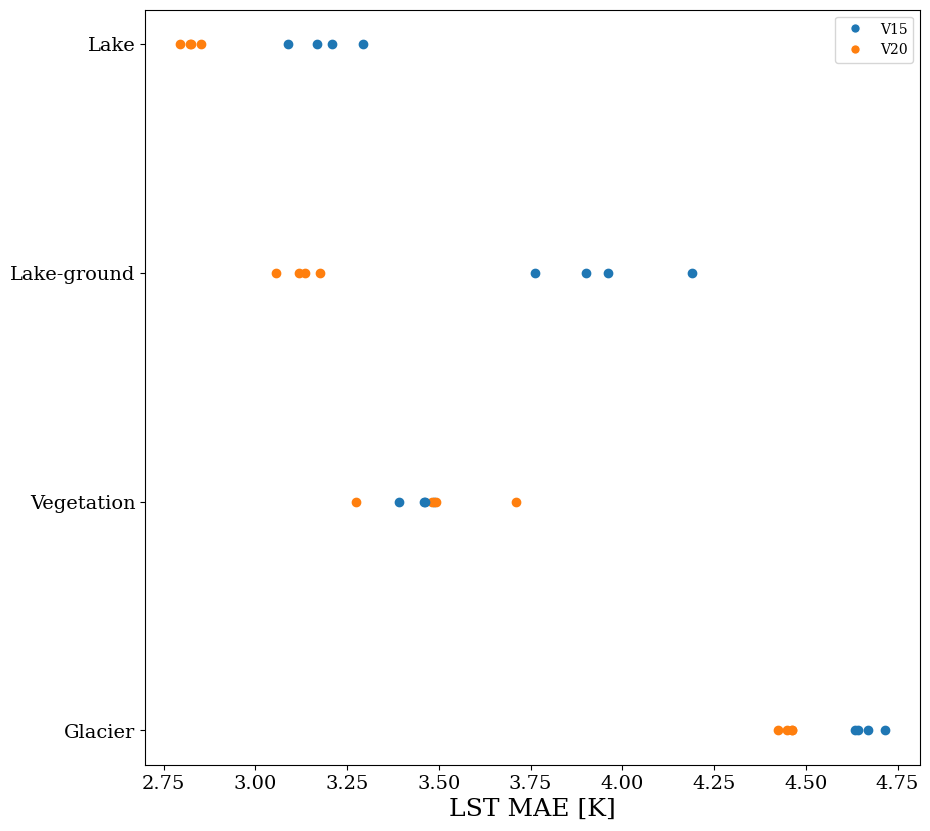

In [145]:
conditions = [lake_condition,lake_ground_condition,vegetation_condition,glacier_condition]
names = ["Lake", "Lake-ground", "Vegetation", "Glacier"]
shift_plot(df_V15,df_V20,conditions,names,savefig="global_shift_plot")

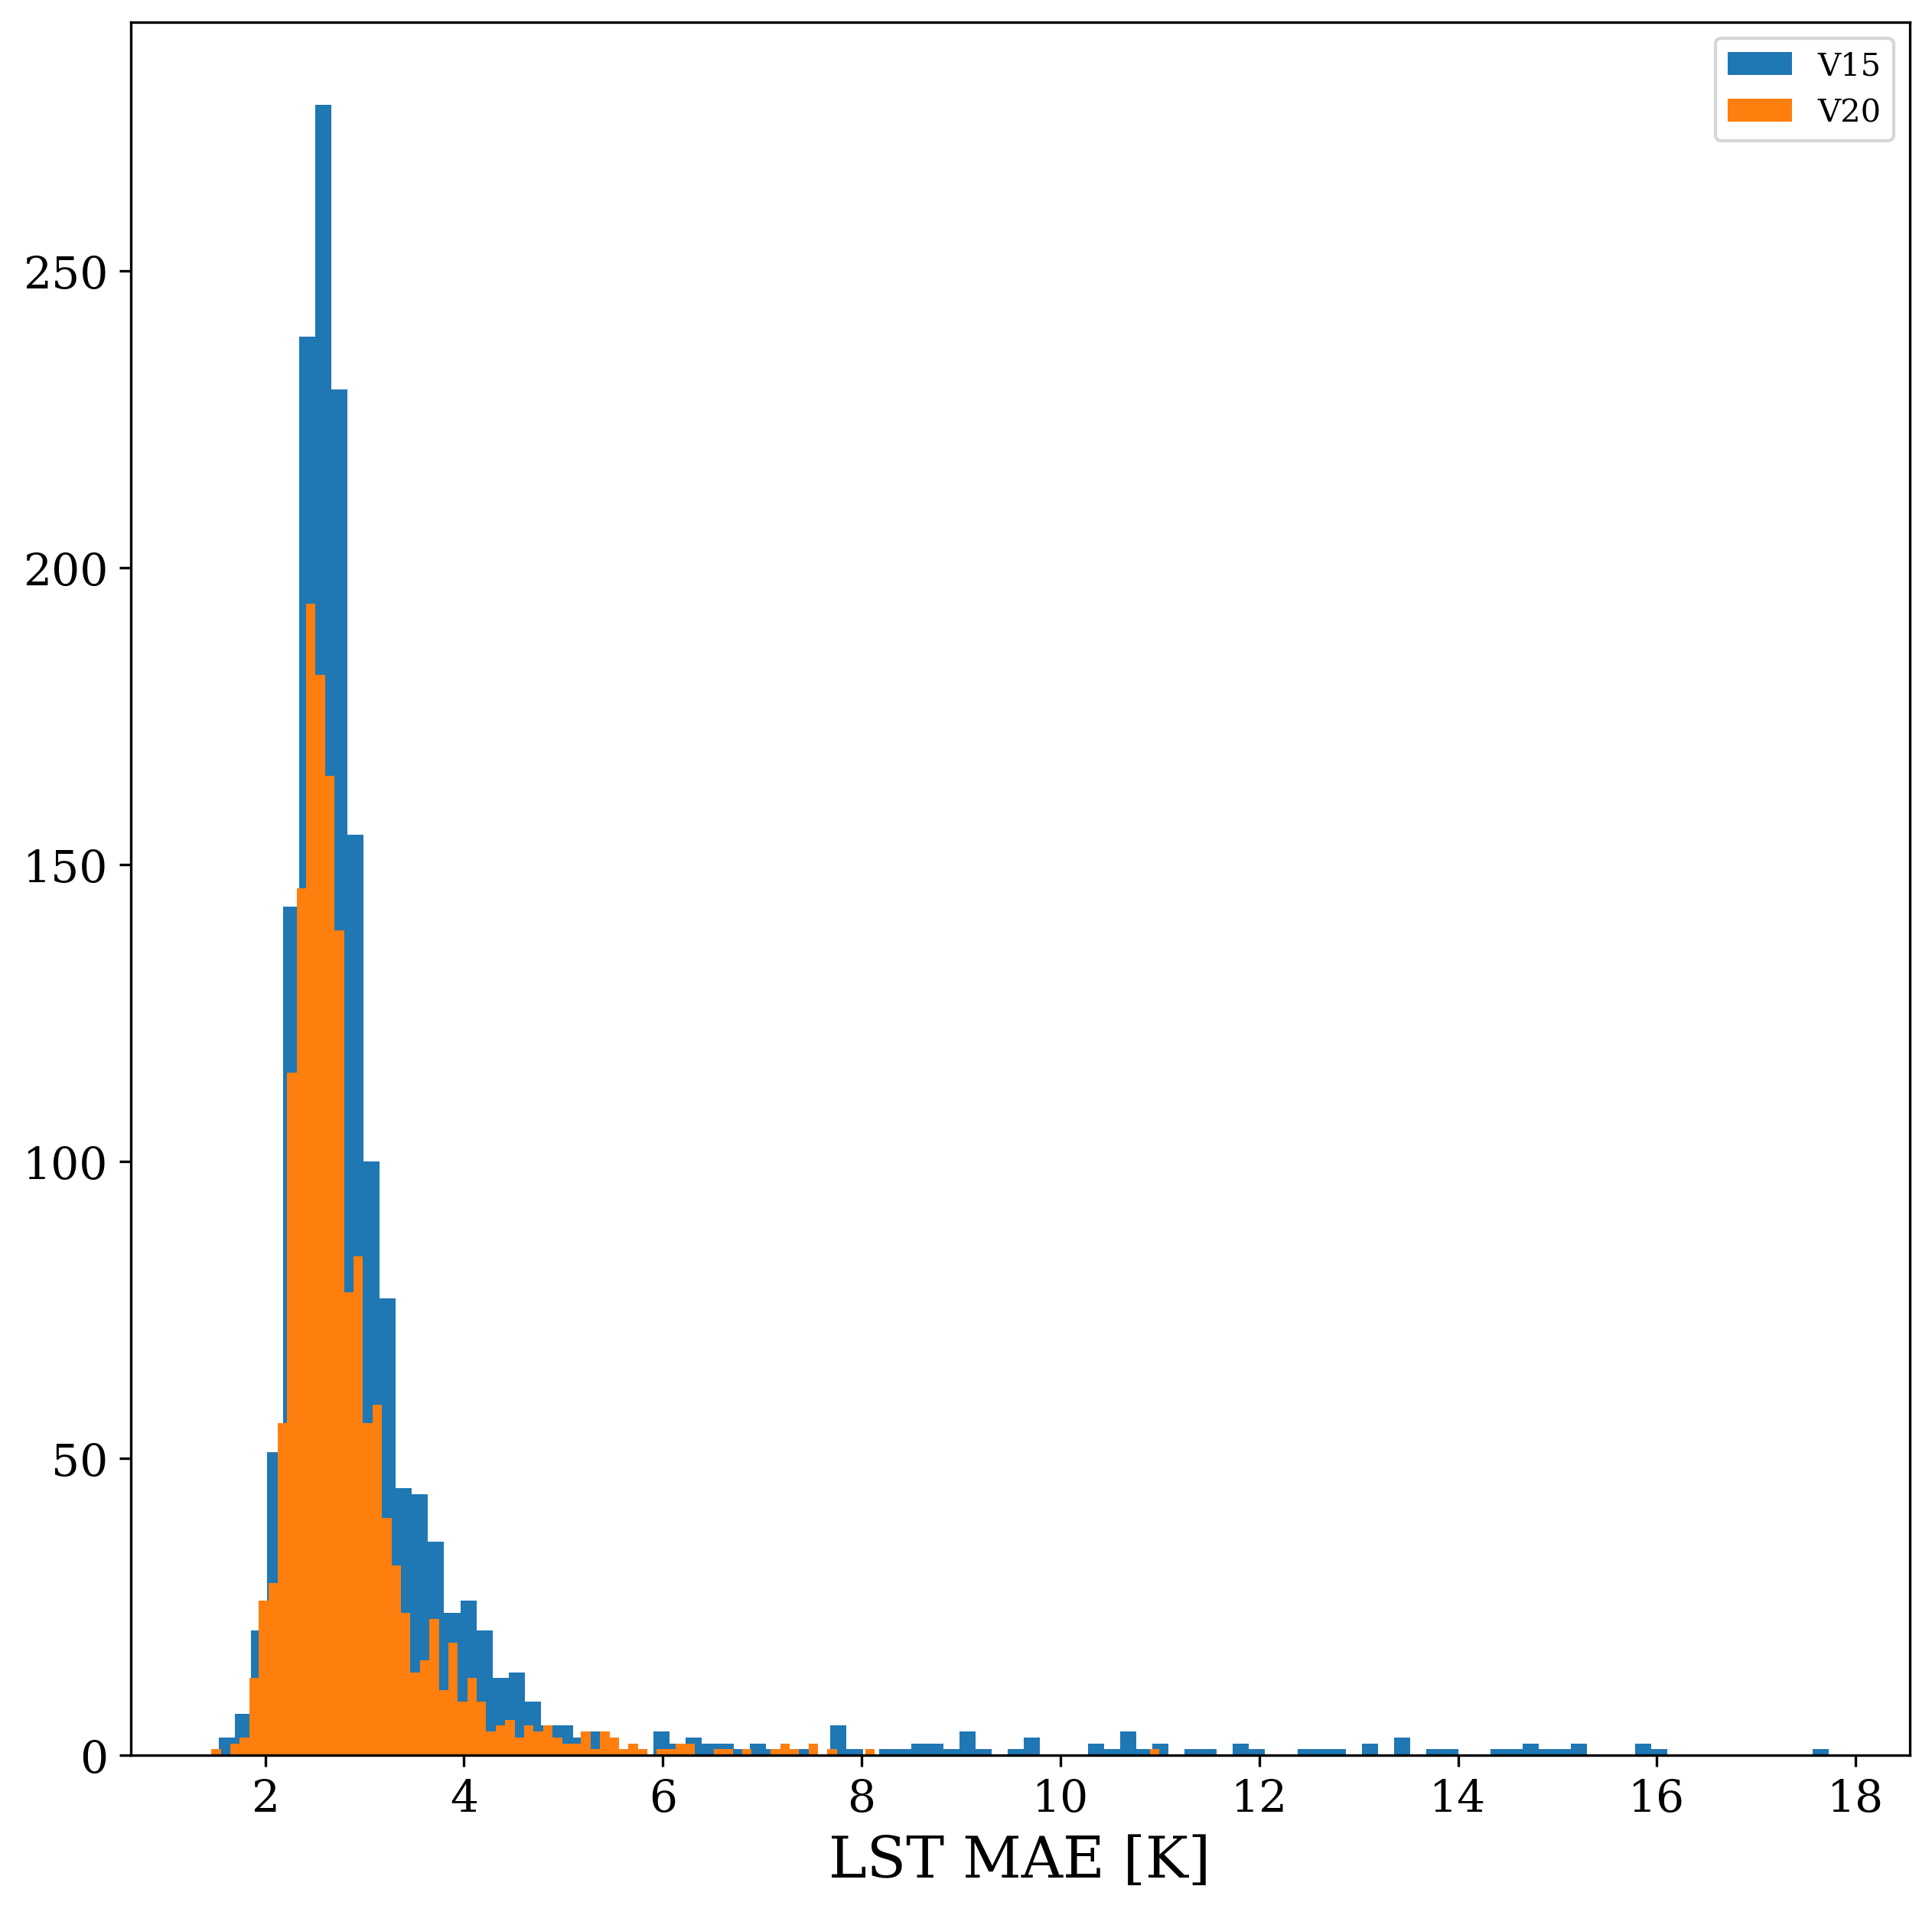

In [146]:
dual_histogram_plot(df_V15.query(lake_condition),df_V20.query(lake_condition),["V15", "V20"],savefig="lakes_histogram_plot")

#### Deep dive on individual bad points

In [147]:
lake_natron_condition                = 'latitude_ERA == -2.3887580539270044 & longitude_ERA == 36.0000'
lake_natron_northern_edge_condition  = 'latitude_ERA == -2.10772769472398 & longitude_ERA == 36.0000'
lake_blanche_condition               ='latitude_ERA ==  -29.367671674745356 & longitude_ERA == 139.6875'
salt_lake_city_condition             ='latitude_ERA ==  41.17094491970063 & longitude_ERA ==  -113.39999999999998'
farah_province_condition             ='latitude_ERA ==  31.615914311651938 & longitude_ERA == 61.120000000000005'
gujarat_province_condition           ='latitude_ERA ==  24.028095261448925 & longitude_ERA ==  69.0'
toshka_lakes_condition               ='latitude_ERA ==  23.18500423251539 & longitude_ERA ==  30.900000000000006'
all_northern_canada_points_condition = '50.0 < latitude_ERA & -130 < longitude_ERA < -80'


caspain_1_condition = 'latitude_ERA ==  46.22948997297545 & longitude_ERA ==   49.125'
caspain_2_condition = 'latitude_ERA ==  46.22948997297545 & longitude_ERA ==    49.5'
caspain_3_condition = 'latitude_ERA ==  46.51052023808231 & longitude_ERA ==    49.5'
caspain_4_condition = 'latitude_ERA ==  47.072580762649004 & longitude_ERA ==    51.599999999999994'
caspian_condition = f"{caspain_1_condition} | {caspain_2_condition} | {caspain_3_condition} | {caspain_3_condition}"


bering_glacier_condition = 'latitude_ERA == 60.280999861571715   & longitude_ERA ==    -143.4666666666667'
juncal_glacier_condition = 'latitude_ERA == -33.021065936911214   & longitude_ERA ==    -70.07999999999998'

In [148]:
all_conditions = [lake_natron_condition,
                 lake_natron_northern_edge_condition,
                  lake_blanche_condition,
                  salt_lake_city_condition,
                  farah_province_condition,
                  gujarat_province_condition,
                  toshka_lakes_condition,
                  all_northern_canada_points_condition,
                  caspian_condition,
                  bering_glacier_condition,
                  juncal_glacier_condition
                 ]

names = ['Lake Natron centre', 
           'Lake Natrom, north', 
           'Lake Blanche',
           'Great Salt Lake Desert', 
           'Farah Province', 
           'Gujarat Province', 
           'Toshka Lakes', 
           'Northern Canada',
           'Caspian',
           'Bering Glacier', 
           'Juncal Glacier',
          ]



In [149]:
i = 0
for c in all_conditions:
    print(names[i])
    i += 1
    
    
    df_v15i = df_V15.query(c)
    df_v20i = df_V20.query(c)
    df_v15Xi = df_V15X.query(c)
    df_v20Xi = df_V20X.query(c)
    summary_stats(df_v15i,df_v15Xi,df_v20i,df_v20Xi)
    
    
    
    
    
    
    
    print("----------------------------")

Lake Natron centre
Summary statistics: 1 || 0.11960212724085519 1.47858092084695 0.813442105272634 0.532326411252551 || 1.3538576364517212 2.4493942260742188 2.60787570476532
----------------------------
Lake Natrom, north
Summary statistics: 1 || 0.12898216535815019 0.37358955256009 0.5115488614307178 0.17506197329081788 || 0.7177065014839172 1.5720474123954773 1.235166609287262
----------------------------
Lake Blanche
Summary statistics: 1 || 0.8293032931757709 0.7001626355410562 1.5380665546606391 0.2771110114251301 || -0.4220413565635681 0.03171432018280029 -0.7499001026153564
----------------------------
Great Salt Lake Desert
Summary statistics: 1 || 0.25926339826174105 0.4126387449589092 0.9199226459606091 0.6171106942215293 || -0.18230682611465454 2.915093958377838 0.24781256914138794
----------------------------
Farah Province
Summary statistics: 1 || 0.01383326811122159 0.19342958741927413 0.08647194690789431 0.21742854468356793 || 0.2193710207939148 0.18824994564056396 -0.1

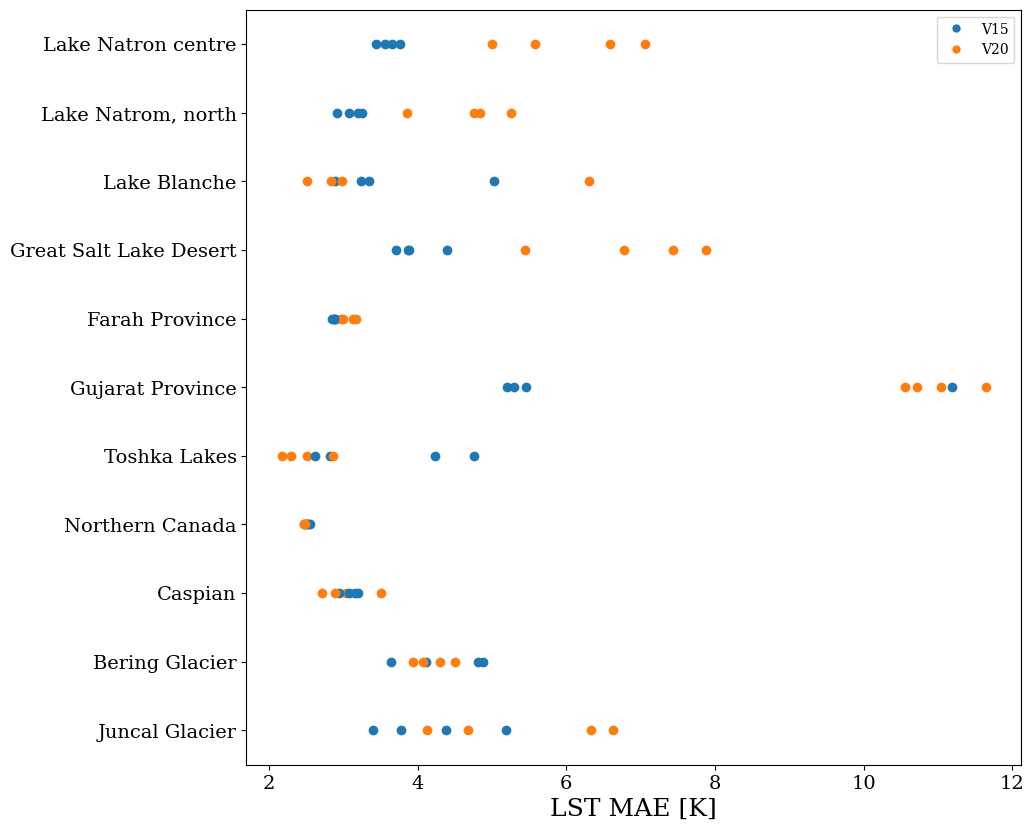

In [150]:
shift_plot(df_V15,df_V20,all_conditions,names,savefig="selected_points_shift_plot")